In [22]:
import numpy as np
import matplotlib.pyplot as plt

def get_gradients_for_task(p, task_no, RUNS):
    data_path_p = f"data/mnist_split/{p}/"
    
    # Initialize lists to collect gradient arrays for each type
    gradients_data1 = []
    gradients_data2 = []
    gradients_data3 = []
    gradients_data4 = []

    for run in range(RUNS):
        run_file_name1 = data_path_p + f"run_{run}/ideal_grad_task_{task_no}/grad_layers.0.bias.npy"
        run_file_name2 = data_path_p + f"run_{run}/ideal_grad_task_{task_no}/grad_layers.0.weight.npy"
        run_file_name3 = data_path_p + f"run_{run}/ideal_grad_task_{task_no}/grad_output_layer.bias.npy"
        run_file_name4 = data_path_p + f"run_{run}/ideal_grad_task_{task_no}/grad_output_layer.weight.npy"
        
        # Load gradient data
        run_data1 = np.load(run_file_name1)
        run_data2 = np.load(run_file_name2)
        run_data3 = np.load(run_file_name3)
        run_data4 = np.load(run_file_name4)
        
        # Append the loaded arrays to their respective lists
        gradients_data1.append(run_data1)
        gradients_data2.append(run_data2)
        gradients_data3.append(run_data3)
        gradients_data4.append(run_data4)

    # Stack arrays for each gradient type if not empty, else create an empty array
    data1 = np.stack(gradients_data1, axis=0) if gradients_data1 else np.array([])
    data2 = np.stack(gradients_data2, axis=0) if gradients_data2 else np.array([])
    data3 = np.stack(gradients_data3, axis=0) if gradients_data3 else np.array([])
    data4 = np.stack(gradients_data4, axis=0) if gradients_data4 else np.array([])

    # Calculate the average across the first dimension (the run dimension)
    avg_data1 = np.mean(data1, axis=0) if data1.size else data1
    avg_data2 = np.mean(data2, axis=0) if data2.size else data2
    avg_data3 = np.mean(data3, axis=0) if data3.size else data3
    avg_data4 = np.mean(data4, axis=0) if data4.size else data4

    return avg_data1, avg_data2, avg_data3, avg_data4

In [23]:
def get_ideal_grad_for_task(task_no):
    data_path_p = f"data/mnist_split/1/"

    run_file_name1 = data_path_p + f"task_{task_no}/grad_layers.0.bias.npy"
    run_file_name2 = data_path_p + f"task_{task_no}/grad_layers.0.weight.npy"
    run_file_name3 = data_path_p + f"task_{task_no}/grad_output_layer.bias.npy"
    run_file_name4 = data_path_p + f"task_{task_no}/grad_output_layer.weight.npy"
        
    data1 = np.load(run_file_name1)
    data2 = np.load(run_file_name2)
    data3 = np.load(run_file_name3)
    data4 = np.load(run_file_name4)
        

    return data1, data2, data3, data4

In [24]:
def calculate_metrics(actual, ideal):
    # Ensure both arrays have the same shape
    if actual.shape != ideal.shape:
        raise ValueError(f"Shape mismatch: {actual.shape} vs {ideal.shape}")
    
    metrics = {}
    actual_flat = actual.flatten()
    ideal_flat = ideal.flatten()

    # MSE
    metrics['MSE'] = np.mean((actual_flat - ideal_flat) ** 2)
    
    # RMSE
    metrics['RMSE'] = np.sqrt(metrics['MSE'])
    
    # MAE
    metrics['MAE'] = np.mean(np.abs(actual_flat - ideal_flat))
    
    # Cosine Similarity
    dot_product = np.dot(actual_flat, ideal_flat)
    norm_actual = np.linalg.norm(actual_flat)
    norm_ideal = np.linalg.norm(ideal_flat)
    metrics['Cosine Similarity'] = dot_product / (norm_actual * norm_ideal) if (norm_actual * norm_ideal) != 0 else 0
    
    # Euclidean Distance
    metrics['Euclidean Distance'] = np.linalg.norm(actual_flat - ideal_flat)
    
    return metrics

In [25]:
def flatten_and_concatenate_arrays(arrays_tuple):
    """Flatten each array in the tuple and concatenate them into a single array."""
    flattened_arrays = [arr.flatten() for arr in arrays_tuple]
    concatenated_array = np.concatenate(flattened_arrays)
    return concatenated_array

In [26]:

def plot_all_metrics(task_no, RUNS):
    p_values = [0.1, 0.2, 0.3, 0.4, 0.5, 0.6, 0.7, 0.8, 0.9]
    
    fig, axs = plt.subplots(3, 3, figsize=(18, 12))  # Adjust grid size as needed
    fig.tight_layout(pad=3.0)
    
    fig.suptitle(f'Distance between gradients for task {task_no}', fontsize=16, y=1.02)
    
    y_min, y_max = float('inf'), float('-inf')
    
    for i, p in enumerate(p_values):
        row = i // 3
        col = i % 3
        gradients = get_gradients_for_task(p, task_no, RUNS)
        ideal_gradients = get_ideal_grad_for_task(task_no)
        
        ax = axs[row, col]
        plot_metrics_for_p(p, gradients, ideal_gradients, ax)
        
        y_min_temp, y_max_temp = ax.get_ylim()
        y_min = min(y_min, y_min_temp)
        y_max = max(y_max, y_max_temp)
    
    for ax in axs.flat:
        ax.set_ylim([y_min, y_max])
    
    plt.show()

def plot_metrics_for_p(p, gradients, ideal_gradients, ax):
    metrics_names = ['MSE', 'RMSE', 'MAE', 'Cosine Similarity', 'Euclidean Distance']
    data_labels = ['layer bias', 'layer weights', 'output bias', 'output weights']
    
    metrics_results = {metric: [] for metric in metrics_names}
    
    for i in range(len(gradients)):
        if gradients[i].shape == ideal_gradients[i].shape:
            metrics = calculate_metrics(gradients[i], ideal_gradients[i])
            for metric in metrics_names:
                metrics_results[metric].append(metrics[metric])
    
    x = np.arange(len(data_labels))
    width = 0.15

    for i, metric in enumerate(metrics_names):
        ax.bar(x + i*width, metrics_results[metric], width, label=metric)

    ax.set_xlabel('Loss Gradient')
    ax.set_ylabel('Metric Value')
    ax.set_title(f'Metrics for p={p}')
    ax.set_xticks(x + width * len(metrics_names) / 2)
    ax.set_xticklabels(data_labels)
    ax.legend()

def plot_all_metrics_single_gradient(task_no, RUNS):
    p_values = [0.1, 0.2, 0.3, 0.4, 0.5, 0.6, 0.7, 0.8, 0.9]
    
    colors = ['blue', 'orange', 'green', 'red', 'purple']
    
    fig, axs = plt.subplots(3, 3, figsize=(18, 12), sharey=True)  
    fig.tight_layout(pad=3.0)
    
    fig.suptitle(f'Distance between gradients for task {task_no}', fontsize=16, y=1.02)
    
    for i, p in enumerate(p_values):
        row = i // 3
        col = i % 3
        gradient = flatten_and_concatenate_arrays(get_gradients_for_task(p, task_no, RUNS))
        ideal_gradient = flatten_and_concatenate_arrays(get_ideal_grad_for_task(task_no))   
        
        ax = axs[row, col]
        plot_metrics_for_single_gradient(p, gradient, ideal_gradient, ax, colors)
    
    plt.legend(loc='upper center', bbox_to_anchor=(-0.1, -0.1), fancybox=True, shadow=True, ncol=5)
    plt.show()

def plot_metrics_for_single_gradient(p, gradient, ideal_gradient, ax, colors):
    metrics_names = ['MSE', 'RMSE', 'MAE', 'Cosine Similarity', 'Euclidean Distance']
    
    metrics = calculate_metrics(gradient, ideal_gradient)
    metrics_values = [metrics[name] for name in metrics_names]

    for i, (metric, value) in enumerate(zip(metrics_names, metrics_values)):
        ax.bar(metric, value, label=f'{metric}', color=colors[i])

    ax.set_ylabel('Metric Value')
    ax.set_title(f'Metrics for p={p}')





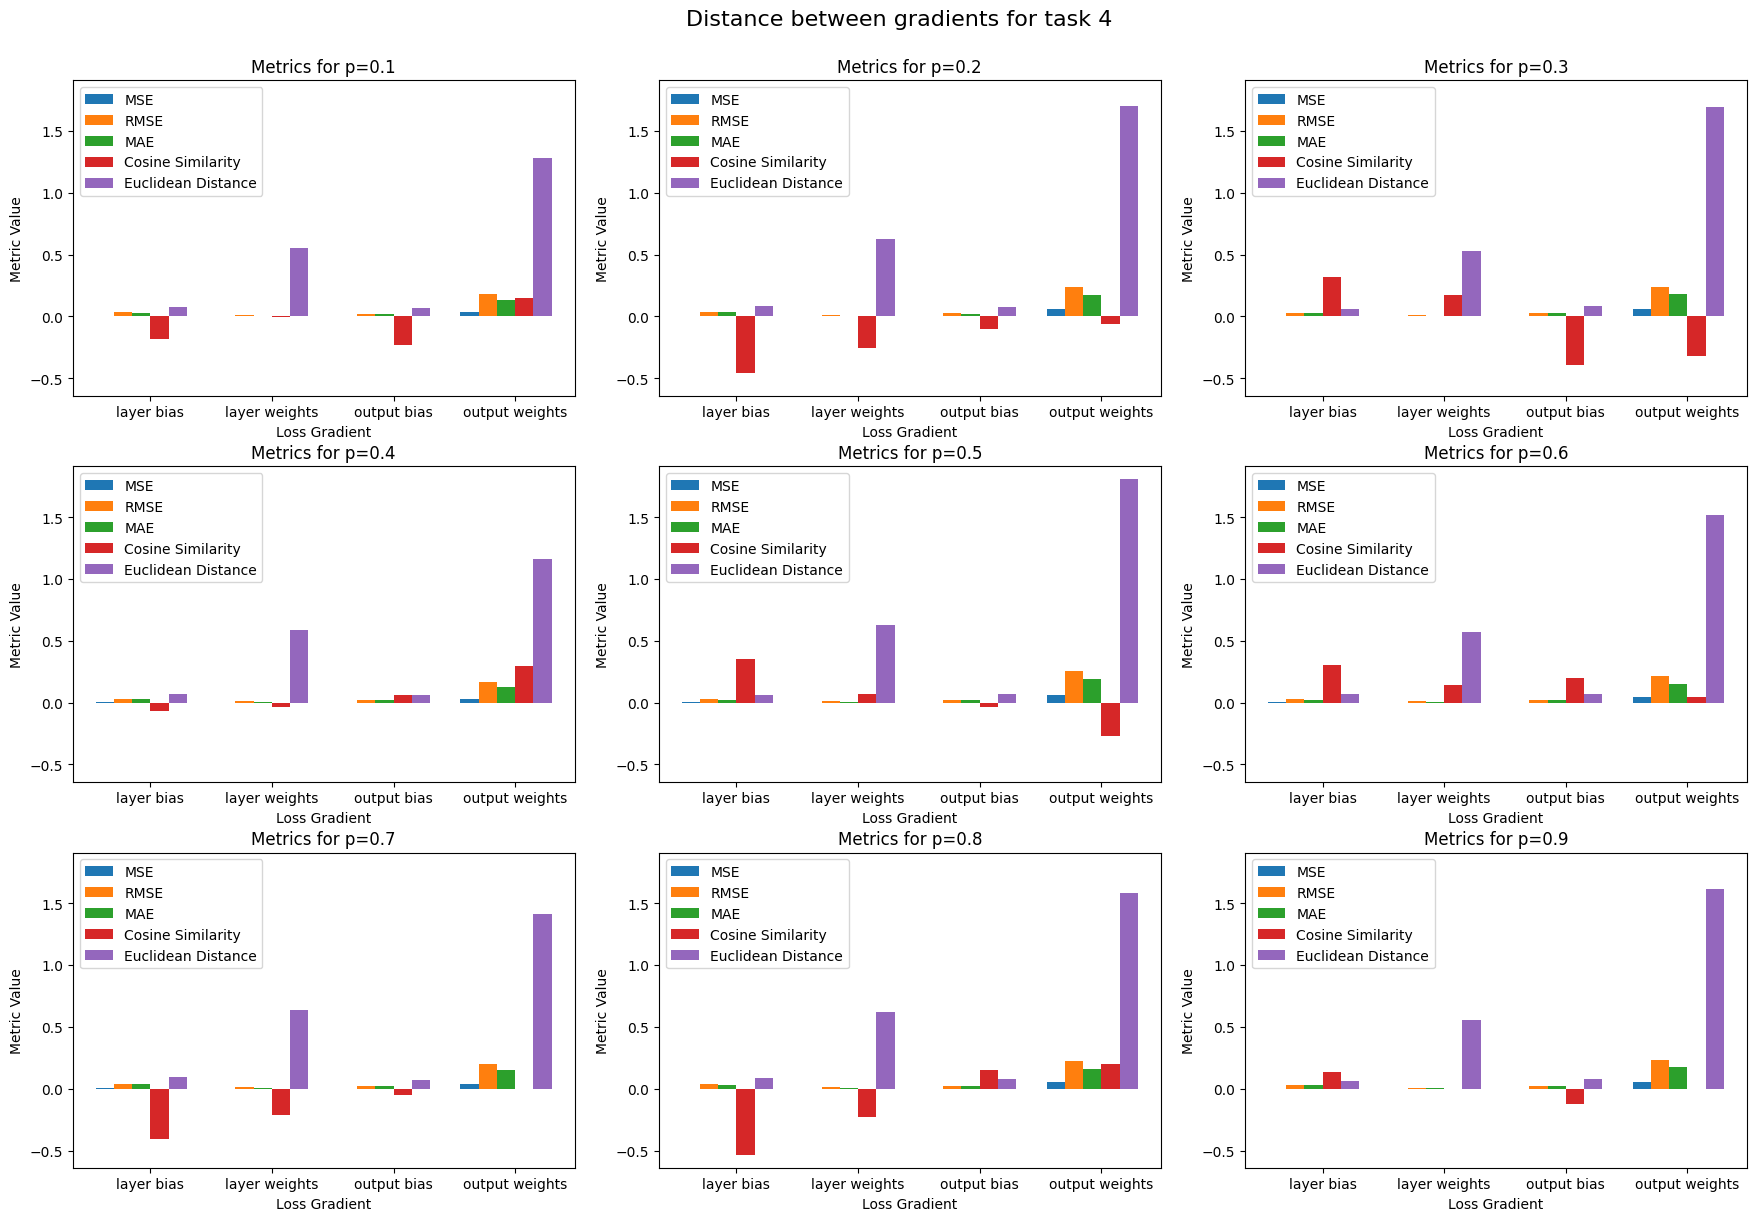

In [40]:
p = 0.1
data_path = "data/mnist_split"
data_path_p = f"data/mnist_split/{p}/"
task = 4
RUNS = 10
p = 0.1
p_values = [0.1, 0.2, 0.3, 0.4, 0.5, 0.6, 0.7, 0.8, 0.9]

# plot_all_metrics(task_no, RUNS)
plot_all_metrics(4, RUNS)


In [41]:
# gradients = flatten_and_concatenate_arrays(get_gradients_for_task(p, task_no, RUNS))
# ideal_gradients = flatten_and_concatenate_arrays(get_ideal_grad_for_task(task_no))

gradients = flatten_and_concatenate_arrays(get_gradients_for_task(0.1, 1, RUNS))
ideal_gradients = flatten_and_concatenate_arrays(get_ideal_grad_for_task(1))

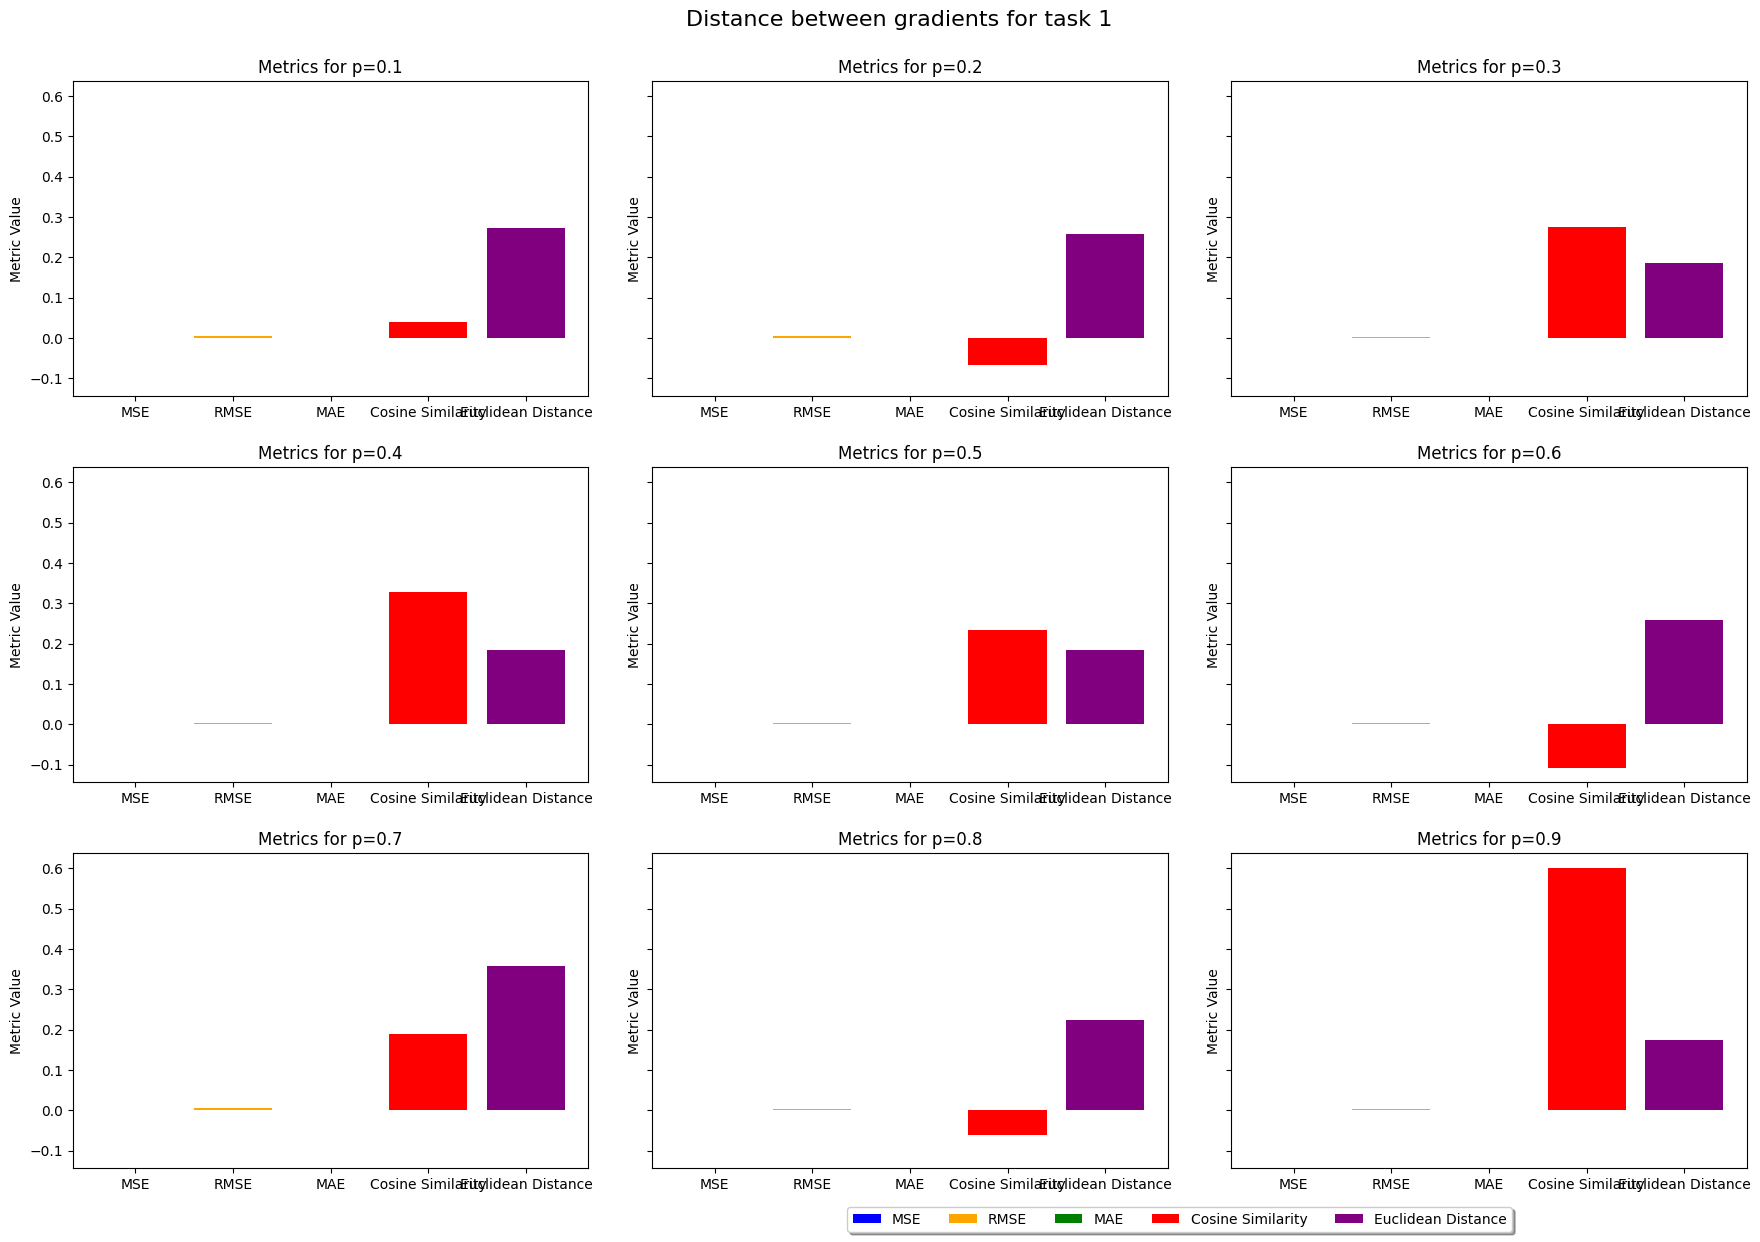

In [42]:
plot_all_metrics_single_gradient(1, RUNS)